# Proyecto Control Óptimo: Deep Learning como problema de Control Óptimo

## Estudio de datos reales

*Universidad de Chile*  
*Facultad de Ciencias Físicas y Matemáticas*  
*Departamento de Ingeniería Matemática*

**MA4703-1 Control Óptimo: Teoría y Laboratorio**  
**Profesor:** Héctor Ramírez C.   
**Auxiliares:** Joaquín Márquez & Sebastián P. Pincheira   
**Ayudante:** Fraick Reyes

**Integrantes:** David Felipe, Alonso Urbina

### Importar liberías y código necesario
___

In [ ]:
import sys, os
import matplotlib.pyplot as plt
import torch
import pandas as pd
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.datasets import fetch_openml

sys.path.append(os.path.abspath("../src"))

from activations import *
from model import ResNetEuler
from train import *

In [2]:
FIG_PATH = "../figures/"

### Datos de Diabetes
___

In [ ]:
url = "https://raw.githubusercontent.com/jbrownlee/Datasets/master/pima-indians-diabetes.data.csv"
column_names = [
    "Pregnancies",
    "Glucose",
    "BloodPressure",
    "SkinThickness",
    "Insulin",
    "BMI",
    "DPF",
    "Age",
    "Outcome",
]

print(f"Descargando datos desde {url}...")
df = pd.read_csv(url, names=column_names)
X_raw = df.iloc[:, :-1].values
y_raw = df.iloc[:, -1].values
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_raw)

X = torch.tensor(X_scaled, dtype=torch.float32)
y = torch.tensor(y_raw, dtype=torch.float32)
X_train_np, X_temp_np, y_train_np, y_temp_np = train_test_split(
    X_scaled, y_raw, test_size=0.4, stratify=y_raw, random_state=42
)
X_val_np, X_test_np, y_val_np, y_test_np = train_test_split(
    X_temp_np, y_temp_np, test_size=0.5, stratify=y_temp_np, random_state=42
)

X_train = torch.tensor(X_train_np, dtype=torch.float32)
y_train = torch.tensor(y_train_np, dtype=torch.float32)
X_val = torch.tensor(X_val_np, dtype=torch.float32)
y_val = torch.tensor(y_val_np, dtype=torch.float32)
X_test = torch.tensor(X_test_np, dtype=torch.float32)
y_test = torch.tensor(y_test_np, dtype=torch.float32)

Descargando datos desde https://raw.githubusercontent.com/jbrownlee/Datasets/master/pima-indians-diabetes.data.csv...
Iniciando entrenamiento con 20 épocas...
[0001] loss=0.093760 | acc_tr=75.57% | L=0.03125 | acc_val=75.32%
[0020] loss=0.073915 | acc_tr=80.78% | L=0.0625 | acc_val=74.03%
Iniciando entrenamiento con 20 épocas...
[0001] loss=0.105776 | acc_tr=78.01% | L=0.03125 | acc_val=75.32%
[0020] loss=0.069375 | acc_tr=79.15% | L=0.01562 | acc_val=70.78%
Iniciando entrenamiento con 20 épocas...
[0001] loss=0.101157 | acc_tr=77.04% | L=0.0625 | acc_val=75.32%
[0020] loss=0.077617 | acc_tr=79.80% | L=0.01562 | acc_val=72.73%
Iniciando entrenamiento con 20 épocas...
[0001] loss=0.099594 | acc_tr=73.98% | L=0.01562 | acc_val=81.05%
[0020] loss=0.079460 | acc_tr=75.93% | L=0.03125 | acc_val=78.43%
Iniciando entrenamiento con 20 épocas...
[0001] loss=0.101819 | acc_tr=75.77% | L=0.03125 | acc_val=77.78%
[0020] loss=0.075850 | acc_tr=79.84% | L=0.03125 | acc_val=77.12%


In [ ]:
historial = train_eval_resnet_cv(
    X, y, model_name="ResNetEuler", num_layers=25, epochs=20, delta_t=0.1
)

In [ ]:
historial_df = pd.DataFrame([historial])
display(historial_df)

,model,accuracy,f1,roc_auc,mse,train_time_s
0,ResNetEuler,0.7462 ± 0.0281,0.6222 ± 0.0303,0.8198 ± 0.0336,0.1698 ± 0.0244,0.9342 ± 0.0198


Iniciando entrenamiento con 20 épocas...
[0001] loss=0.099593 | acc_tr=76.52% | L=0.125 | acc_val=73.38%
[0020] loss=0.061317 | acc_tr=86.30% | L=0.125 | acc_val=75.32%
Accuracy en test: 0.7208
F1 Score en test: 0.5825
ROC AUC en test: 0.7741
MSE en test: 0.2272


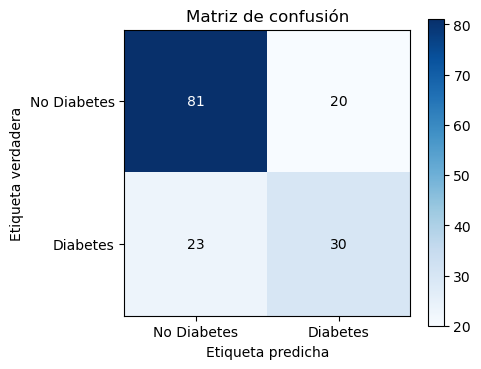

Confusion matrix:
 [[81 20]
 [23 30]]


In [ ]:
model_diabetes = ResNetEuler(
    dim=X.shape[1],
    num_layers=25,
    activation=relu,
    activation_derivative=relu_prime,
    hip_function=sigmoid,
    hip_function_derivative=sigmoid_derivative,
    delta_t=0.1,
)
train_model_backtracking(
    model_diabetes,
    X_train,
    y_train,
    X_val,
    y_val,
    epochs=20,
    end_criterion=1e-6,
    batch_size=8,
)
y_test_pred = model_diabetes(X_test).detach().numpy()
y_test_pred_labels = (y_test_pred >= 0.5).astype(int)
accuracy = accuracy_score(y_test_np, y_test_pred_labels)
f1 = f1_score(y_test_np, y_test_pred_labels)
roc_auc = roc_auc_score(y_test_np, y_test_pred)
mse = mean_squared_error(y_test_np, y_test_pred)
print(f"Accuracy en test: {accuracy:.4f}")
print(f"F1 Score en test: {f1:.4f}")
print(f"ROC AUC en test: {roc_auc:.4f}")
print(f"MSE en test: {mse:.4f}")

cm = confusion_matrix(y_test_np, y_test_pred_labels)
class_names = ["No Diabetes", "Diabetes"]

fig, ax = plt.subplots(figsize=(5, 4))
im = ax.imshow(cm, interpolation="nearest", cmap=plt.cm.Blues)
ax.set_title("Matriz de confusión - Diabetes")
plt.colorbar(im, ax=ax)
tick_marks = [0, 1]
ax.set_xticks(tick_marks)
ax.set_yticks(tick_marks)
ax.set_xticklabels(class_names)
ax.set_yticklabels(class_names)
ax.set_ylabel("Etiqueta verdadera")
ax.set_xlabel("Etiqueta predicha")

thresh = cm.max() / 2.0
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(
            j,
            i,
            format(cm[i, j], "d"),
            ha="center",
            va="center",
            color="white" if cm[i, j] > thresh else "black",
        )

plt.tight_layout()
os.makedirs(FIG_PATH, exist_ok=True)
fig_path = os.path.join(FIG_PATH, "confusion_matrix_diabetes.pdf")
plt.savefig(fig_path)
plt.show()

### Datos de Titanic
Obtenidos desde una competencia de Kaggle con el objetivo de evaluar diferentes modelos de clasificación binaria para predecir la supervivencia de los pasajeros del Titanic.
___

In [49]:
DATA_PATH = "../data/titanic/"
train_titanic = pd.read_csv(os.path.join(DATA_PATH, "train.csv"))
test_titanic = pd.read_csv(os.path.join(DATA_PATH, "test.csv"))

In [50]:
display(train_titanic.head())
print(train_titanic.info())

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB
None


In [51]:
train_titanic.drop(columns=["Name", "Ticket", "Cabin", "Embarked"], inplace=True)
test_titanic.drop(columns=["Name", "Ticket", "Cabin", "Embarked"], inplace=True)
train_titanic["Sex"].replace({"male": 0, "female": 1}, inplace=True)
test_titanic["Sex"].replace({"male": 0, "female": 1}, inplace=True)
train_titanic["Age"].fillna(train_titanic["Age"].median(), inplace=True)
test_titanic["Age"].fillna(test_titanic["Age"].median(), inplace=True)

/tmp/ipykernel_399634/2087570238.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  train_titanic["Sex"].replace({"male": 0, "female": 1}, inplace=True)
/tmp/ipykernel_399634/2087570238.py:3: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  train_titanic["Sex"].replace({"male": 0, "female": 1}, inplac

In [52]:
X_raw = train_titanic.drop(columns=["Survived"], inplace=False).values
y_raw = train_titanic["Survived"].values
X_scaled = scaler.fit_transform(X_raw)
X = torch.tensor(X_scaled, dtype=torch.float32)
y = torch.tensor(y_raw, dtype=torch.float32)
X_train_np, X_temp_np, y_train_np, y_temp_np = train_test_split(
    X_scaled, y_raw, test_size=0.4, stratify=y_raw, random_state=97
)
X_val_np, X_test_np, y_val_np, y_test_np = train_test_split(
    X_temp_np, y_temp_np, test_size=0.5, stratify=y_temp_np, random_state=97
)
X_train = torch.tensor(X_train_np, dtype=torch.float32)
y_train = torch.tensor(y_train_np, dtype=torch.float32)
X_val = torch.tensor(X_val_np, dtype=torch.float32)
y_val = torch.tensor(y_val_np, dtype=torch.float32)
X_test = torch.tensor(X_test_np, dtype=torch.float32)
y_test = torch.tensor(y_test_np, dtype=torch.float32)

In [ ]:
historial = train_eval_resnet_cv(
    X, y, model_name="ResNetEuler", num_layers=50, epochs=20, delta_t=0.1
)

Iniciando entrenamiento con 100 épocas...
[0001] loss=0.097813 | acc_tr=79.63% | L=0.125 | acc_val=83.24%
[0100] loss=0.042203 | acc_tr=89.61% | L=0.125 | acc_val=81.01%
Iniciando entrenamiento con 100 épocas...
[0001] loss=0.100783 | acc_tr=77.42% | L=0.0625 | acc_val=85.39%
[0100] loss=0.045502 | acc_tr=88.36% | L=0.0625 | acc_val=78.65%
Iniciando entrenamiento con 100 épocas...
[0001] loss=0.090740 | acc_tr=66.90% | L=0.03125 | acc_val=64.04%
[0100] loss=0.050668 | acc_tr=87.66% | L=0.007812 | acc_val=79.78%
Iniciando entrenamiento con 100 épocas...
[0001] loss=0.080996 | acc_tr=80.93% | L=0.0625 | acc_val=73.60%
[0100] loss=0.038625 | acc_tr=91.02% | L=0.125 | acc_val=75.84%
Iniciando entrenamiento con 100 épocas...
[0001] loss=0.089658 | acc_tr=80.93% | L=0.0625 | acc_val=74.72%
[0100] loss=0.042617 | acc_tr=90.88% | L=0.0625 | acc_val=76.97%


In [55]:
display(pd.DataFrame([historial]))

,model,accuracy,f1,roc_auc,mse,train_time_s
0,ResNetEuler,0.7845 ± 0.0186,0.7161 ± 0.0276,0.8330 ± 0.0245,0.1687 ± 0.0179,12.7653 ± 0.6759


Iniciando entrenamiento con 20 épocas...
[0001] loss=0.084740 | acc_tr=78.65% | L=0.03125 | acc_val=75.28%
[0020] loss=0.064571 | acc_tr=83.90% | L=0.01562 | acc_val=76.40%
Accuracy en test: 0.8212
F1 Score en test: 0.7746
ROC AUC en test: 0.8452
MSE en test: 0.1437


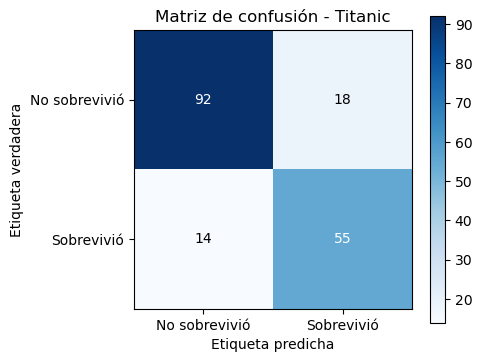

In [58]:
model_titanic = ResNetEuler(
    dim=X.shape[1],
    num_layers=50,
    activation=tanh,
    activation_derivative=tanh_derivative,
    hip_function=sigmoid,
    hip_function_derivative=sigmoid_derivative,
    delta_t=0.1,
)
train_model_backtracking(
    model_titanic,
    X_train,
    y_train,
    X_val,
    y_val,
    epochs=20,
    end_criterion=1e-6,
    batch_size=32,
)
y_test_pred = model_titanic(X_test).detach().numpy()
y_test_pred_labels = (y_test_pred >= 0.5).astype(int)
accuracy = accuracy_score(y_test_np, y_test_pred_labels)
f1 = f1_score(y_test_np, y_test_pred_labels)
roc_auc = roc_auc_score(y_test_np, y_test_pred)
mse = mean_squared_error(y_test_np, y_test_pred)
print(f"Accuracy en test: {accuracy:.4f}")
print(f"F1 Score en test: {f1:.4f}")
print(f"ROC AUC en test: {roc_auc:.4f}")
print(f"MSE en test: {mse:.4f}")

cm = confusion_matrix(y_test_np, y_test_pred_labels)
class_names = ["No sobrevivió", "Sobrevivió"]

fig, ax = plt.subplots(figsize=(5, 4))
im = ax.imshow(cm, interpolation="nearest", cmap=plt.cm.Blues)
ax.set_title("Matriz de confusión - Titanic")
plt.colorbar(im, ax=ax)
tick_marks = [0, 1]
ax.set_xticks(tick_marks)
ax.set_yticks(tick_marks)
ax.set_xticklabels(class_names)
ax.set_yticklabels(class_names)
ax.set_ylabel("Etiqueta verdadera")
ax.set_xlabel("Etiqueta predicha")

thresh = cm.max() / 2.0
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(
            j,
            i,
            format(cm[i, j], "d"),
            ha="center",
            va="center",
            color="white" if cm[i, j] > thresh else "black",
        )

plt.tight_layout()
os.makedirs(FIG_PATH, exist_ok=True)
fig_path = os.path.join(FIG_PATH, "confusion_matrix_titanic.pdf")
plt.savefig(fig_path)
plt.show()

Resolvemos el problema de clasificación planteado por Kaggle para enviar nuestras predicciones sobre el conjunto de test.

In [59]:
test_preds = model_titanic(
    torch.tensor(scaler.transform(test_titanic.values), dtype=torch.float32)
)
test_preds_labels = (test_preds.detach().numpy() >= 0.5).astype(int)
submission = pd.DataFrame(
    {
        "PassengerId": test_titanic["PassengerId"],
        "Survived": test_preds_labels.flatten(),
    }
)
submission.to_csv(os.path.join(DATA_PATH, "titanic_submission.csv"), index=False)

___